In [1]:
import pandas as pd
import gensim
from keras_preprocessing import image as im
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import csv
sns.set()

/home/volodymyr/Parallel-emotional-intent-clustering/env/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Functions

In [2]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations, df

In [3]:
def make_inertia_plot(data,number=20):
    inertia_list = []
    list_clusters = []
    for i in range(3,number+1):
        kmeans = KMeans(n_clusters=i).fit(data)
        inertia_list.append(kmeans.inertia_)
        list_clusters.append(i)
    plt.figure(figsize=(12,8))
    plt.title('Elbow method')
    plt.scatter(list_clusters,inertia_list,s=50, color='r')
    plt.plot(list_clusters,inertia_list)
    plt.xticks(range(1,number+1))

In [4]:
def show_cluster_annotations(annotations, images, labels, n_labels=3, n_annotations=5):
    unique_labels = np.random.choice(list(set(labels)),n_labels,replace=False)
    for label in unique_labels:
        idx  = np.hstack(np.where(labels==label))
        tmp_annotations = np.random.choice(annotations[idx], n_annotations,replace=False)
        for annotation in tmp_annotations:
            tmp_idx = np.hstack(np.where(annotations==annotation))
            plt.figure() 
            plt.imshow(images[tmp_idx][0])
            plt.title('Annotations for label {} :'.format(label))
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(annotation)
        


In [5]:
def show_cluster_images(images, labels, n_labels=3, n_images=5):
    unique_labels = np.random.choice(list(set(labels)),size=n_labels,replace=False)
    rows = len(unique_labels)
    fig, axes = plt.subplots(rows, n_images, figsize=(20,20))
    for c1, label in enumerate(unique_labels):
        idx = np.hstack(np.where(labels==label))
        tmp_images = images[idx]
        to_show = tmp_images[np.random.choice(range(len(tmp_images)), size=n_images,replace=False)]
        for c2, image in enumerate(to_show):
            axes[c1][c2].imshow(image)
            axes[c1][c2].set_ylabel(label)
            axes[c1][c2].grid(False)
            axes[c1][c2].set_yticklabels([])
            axes[c1][c2].set_xticklabels([])


In [6]:
def read_features(path):
    features = []
    with open(path, 'r') as f:
        csv_reader = csv.reader(f, delimiter="\t")
        for row in csv_reader:
            features.append(row)
    return np.array(features)

In [7]:
def metrics(res1,res2):
    adi = adjusted_rand_score(res1, res2)*100
    nmi = normalized_mutual_info_score(res1, res2)*100
    return adi, nmi

In [8]:
def cluster(features, n_clusters=9, pca=False, variance=0.9):
    if isinstance(features, str):
        features = read_features(features)
    if pca:
        features = PCA(variance).fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0)
    kmeans = kmeans.fit(features)
    predictions = kmeans.predict(features)
    return predictions

In [9]:
def sentiment_clustering(df, path_feature, pca=False, variance=0.9):
    n_clusters = df['correct_sentiment'].nunique()
    predictions = cluster(path_feature, n_clusters,pca, variance)
    return metrics(predictions, df['correct_sentiment'].values)

# Loading data

In [10]:
images, annotations, df = load_data("../../data/emo-at-cap/images/", '../../data/emo-at-cap/emo-at-cap.csv')

In [11]:
len(annotations)

3840

In [12]:
mapping_sentiments = dict([(i,c) for c,i in enumerate(df['human_sentiment'].unique())])

In [13]:
df['correct_sentiment'] = df['human_sentiment'].map(mapping_sentiments)

In [14]:
df.head()

,image_name,annotation,human_sentiment,sentiment,correct_sentiment
0,../../data/emo-at-cap/images/nm1055413_rm70404...,The man is running from something,Neutral,Neutral,0
1,../../data/emo-at-cap/images/nm0000113_rm13102...,The worried woman is carrying for the other woman,Positive,Negative,1
2,../../data/emo-at-cap/images/nm0001713_rm27135...,The man and the woman are trying to protect th...,Positive,Positive,1
3,../../data/emo-at-cap/images/nm4237013_rm66314...,The man is flirting with the woman,Positive,Positive,1
4,../../data/emo-at-cap/images/nm0000113_rm13502...,The man and the woman are surprised by something,Positive,Positive,1


In [15]:
df['correct_sentiment'].unique()

array([0, 1, 2])

# Clustering with respect to sentiment

In [16]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

### text

In [17]:
text_features_sentiment_table = []
for text_feature_name in os.listdir('../text_features/'):
    adi, nmi = sentiment_clustering(df, os.path.join('../text_features/',text_feature_name))
    text_features_sentiment_table.append((text_feature_name.split('.')[0], adi, nmi))
text_features_sentiment_table = pd.DataFrame(text_features_sentiment_table, columns=['representation',
                                                                                     'adi','nmi'])

In [18]:
text_features_sentiment_table

,representation,adi,nmi
0,glove,1.566359,1.286910
1,gpt2_11th_layer,0.468994,0.663067
2,gpt2_last_layer,1.406013,0.659126
3,bert_emb,2.187672,1.850855
4,fasttext,1.509329,1.151560
5,elmo,2.913744,2.210550
6,gpt2_wte,1.398828,1.104982
7,stbs_bert,39.213740,32.689471
8,gpt_4_last_layers,-0.085087,0.518558
9,w2v,2.908253,2.150396


### images

In [19]:
image_features_sentiment_table = []
for image_feature_name in os.listdir('../image_features/'):
    adi, nmi = sentiment_clustering(df, os.path.join('../image_features/',image_feature_name))
    image_features_sentiment_table.append((image_feature_name.split('.')[0], adi, nmi))
image_features_sentiment_table = pd.DataFrame(image_features_sentiment_table, columns=['image_model','adi','nmi'])

In [20]:
image_features_sentiment_table

,image_model,adi,nmi
0,efnet_top_conv_age_gender,-0.152606,0.084878
1,resnet_conv5_block3,-0.551325,0.924232
2,resnet_fer_last,-0.538623,0.356185
3,resnet_conv4_block5,0.778172,1.235620
4,hierarchy_based_sim,-0.230801,0.160358
5,efnet_bloc3c_age_gender,0.134495,0.063675


In [21]:
text_features_sentiment_table.to_csv('sentiment_clustering_text.csv', index=False)
image_features_sentiment_table.to_csv('sentiment_clustering_images.csv', index=False)

## trying out PCA to get rid of noise 

### text

In [22]:
text_features_sentiment_table_pca = []
for text_feature_name in os.listdir('../text_features/'):
    adi, nmi = sentiment_clustering(df, os.path.join('../text_features/',text_feature_name), pca=True, variance=0.9)
    text_features_sentiment_table_pca.append((text_feature_name.split('.')[0], adi, nmi))
text_features_sentiment_table_pca = pd.DataFrame(text_features_sentiment_table_pca, columns=['representation',
                                                                                     'adi','nmi'])

In [23]:
pd.concat([text_features_sentiment_table,text_features_sentiment_table_pca], axis=1)

,representation,adi,nmi,representation,adi,nmi
0,glove,1.566359,1.286910,glove,1.558309,1.282746
1,gpt2_11th_layer,0.468994,0.663067,gpt2_11th_layer,0.471864,0.654050
2,gpt2_last_layer,1.406013,0.659126,gpt2_last_layer,1.344460,0.521003
3,bert_emb,2.187672,1.850855,bert_emb,2.187672,1.850855
4,fasttext,1.509329,1.151560,fasttext,1.483204,1.135965
5,elmo,2.913744,2.210550,elmo,2.913068,2.220243
6,gpt2_wte,1.398828,1.104982,gpt2_wte,1.407528,1.112437
7,stbs_bert,39.213740,32.689471,stbs_bert,38.290149,32.414996
8,gpt_4_last_layers,-0.085087,0.518558,gpt_4_last_layers,-0.083651,0.501086
9,w2v,2.908253,2.150396,w2v,2.862026,2.101507


### images

In [24]:
image_features_sentiment_table_pca = []
for image_feature_name in os.listdir('../image_features/'):
    adi, nmi = sentiment_clustering(df, os.path.join('../image_features/',image_feature_name), pca=True, variance=0.9)
    image_features_sentiment_table_pca.append((image_feature_name.split('.')[0], adi, nmi))
image_features_sentiment_table_pca = pd.DataFrame(image_features_sentiment_table_pca, columns=['image_model','adi','nmi'])

In [25]:
pd.concat([image_features_sentiment_table,image_features_sentiment_table_pca],axis=1)

,image_model,adi,nmi,image_model,adi,nmi
0,efnet_top_conv_age_gender,-0.152606,0.084878,efnet_top_conv_age_gender,-0.164945,0.088318
1,resnet_conv5_block3,-0.551325,0.924232,resnet_conv5_block3,-0.542088,0.934067
2,resnet_fer_last,-0.538623,0.356185,resnet_fer_last,-0.536282,0.379422
3,resnet_conv4_block5,0.778172,1.235620,resnet_conv4_block5,0.798147,1.253139
4,hierarchy_based_sim,-0.230801,0.160358,hierarchy_based_sim,-0.230801,0.160358
5,efnet_bloc3c_age_gender,0.134495,0.063675,efnet_bloc3c_age_gender,0.145626,0.065771


# Clustering with KMeans to determine understanding between images and text

In [26]:
from yellowbrick.cluster import KElbowVisualizer


In [27]:
def get_n_clusters(features, k=(1,12)):
    visualizer = KElbowVisualizer(KMeans(), k=k)
    visualizer.fit(features.astype(np.float64))
    return visualizer.elbow_value_

In [28]:
def deterimne_clusters(features1, features2):
    n_clusters1 = get_n_clusters(features1)
    n_clusters2 = get_n_clusters(features2)
    return np.floor((n_clusters1+n_clusters2)/2).astype(int)


In [29]:
def text_images_clustering():
    list_features_text = os.listdir('../text_features/')
    list_features_images = os.listdir('../image_features/')
    results = []
    for feature_text in tqdm(list_features_text):
        name_feature_text = feature_text.split('.')[0]
        feature_text = read_features(os.path.join('../text_features/', feature_text))
        for feature_image in tqdm(list_features_images):
            name_feature_image = feature_image.split('.')[0]
            feature_image = read_features(os.path.join('../image_features/', feature_image))
            k = deterimne_clusters(feature_text,feature_image)
            adi, nmi = metrics(cluster(feature_image, n_clusters=k),cluster(feature_text, n_clusters=k))
            results.append((name_feature_text,name_feature_image, adi, nmi, k))
    return pd.DataFrame(results, columns=['representation_text','representation_images','adi','nmi','n_clusters'])

100%|██████████| 12/12 [1:22:32<00:00, 412.71s/it]


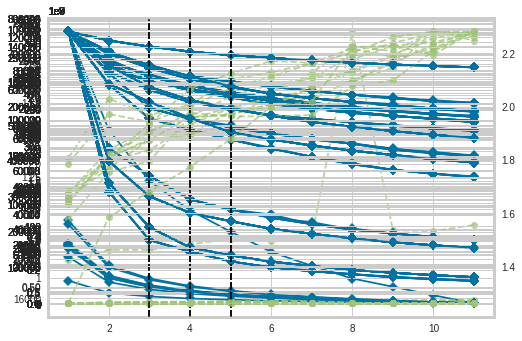

In [30]:
text_images_table = text_images_clustering()

In [31]:
text_images_table

,representation_text,representation_images,adi,nmi,n_clusters
0,glove,efnet_top_conv_age_gender,1.438598,1.673156,3
1,glove,resnet_conv5_block3,2.301925,2.974737,4
2,glove,resnet_fer_last,0.556764,0.180679,3
3,glove,resnet_conv4_block5,2.060940,2.320899,4
4,glove,hierarchy_based_sim,-0.282315,0.397759,4
...,...,...,...,...,...
67,bert_last_layer,resnet_conv5_block3,1.066965,1.639509,5
68,bert_last_layer,resnet_fer_last,0.973428,0.561105,4
69,bert_last_layer,resnet_conv4_block5,0.435249,0.725266,4
70,bert_last_layer,hierarchy_based_sim,-0.045452,0.312184,5


In [32]:
text_images_table['n_clusters'].max()

5

In [33]:
text_images_table[text_images_table.nmi==text_images_table.nmi.max()]

,representation_text,representation_images,adi,nmi,n_clusters
55,w2v,resnet_conv5_block3,2.512436,3.210155,4


In [34]:
df_adi = pd.pivot_table(text_images_table, values='adi',index=text_images_table['representation_text'], columns=text_images_table['representation_images'])

In [35]:
df_nmi = pd.pivot_table(text_images_table, values='nmi',index=text_images_table['representation_text'], columns=text_images_table['representation_images'])

In [36]:
df_adi.to_csv('correspondence_clustering_adi.csv',index=False)
df_nmi.to_csv('correspondence_clustering_nmi.csv',index=False)